# Crime Project - Final Data Analysis

### Changes in Shooting Rates in New York City over Time

Our project will focus on multi-year shooting incidents in New York City. We will compare policing methodologies of the NYPD and how their shooting rate has changed over time. The goal will be to measure the success of applied methodologies by analyzing changes in shootings over a 14-year period. 

## Importing Dependencies & Data

In [1]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gmaps
import fiona
import geopandas
import json
import scipy.stats as sts
from scipy.stats import linregress

# Google developer API key
from api_keys import g_key

# Configure gmaps
gmaps.configure(api_key=g_key)

In [2]:
# Store filepath in a variable and load the data into a dataframe
# History NYC shooting data 2006-2019 & year-to-date data for 2020
# Append the 2 dataframes
shooting_crime_file_historic = "Resources/NYPD_Shooting_Incident_Data__Historic_.csv"
shooting_crime_ytd = "Resources/NYPD_Shooting_Incident_Data__Year_To_Date_.csv"

shooting_df_historic = pd.read_csv(shooting_crime_file_historic)
shooting_df_ytd = pd.read_csv(shooting_crime_ytd)

shooting_df = shooting_df_historic.append(shooting_df_ytd)
shooting_df.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,156430715,09/02/2016,20:36:00,BRONX,44,0.0,NaN,False,NaN,NaN,NaN,25-44,F,BLACK,1007885,246406,40.842979,-73.914580,POINT (-73.91457972899997 40.842979335000045)
1,145001700,08/02/2015,1:30:00,BRONX,43,0.0,NaN,False,NaN,NaN,NaN,<18,F,BLACK,1023203,238742,40.821890,-73.859262,POINT (-73.85926192199997 40.82188959900003)
2,137584243,07/04/2014,22:39:00,MANHATTAN,32,0.0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1000493,236572,40.816005,-73.941320,POINT (-73.94131972799995 40.81600451200006)
3,154563857,07/03/2016,1:30:00,BROOKLYN,83,0.0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1008115,190458,40.689416,-73.913947,POINT (-73.91394709799994 40.68941602700004)
4,33160009,07/17/2007,23:30:00,BROOKLYN,71,0.0,NaN,False,NaN,NaN,NaN,<18,M,BLACK,995163,178527,40.656694,-73.960670,POINT (-73.96066977199997 40.656693553000025)


In [3]:
# NYC population data
boroughs = ["BRONX","BROOKLYN","MANHATTAN","QUEENS","STATEN ISLAND"]
counties = ["Bronx","Kings","New York","Queens","Richmond"]
population_estimate = [1418207,2559903,1628706,2253858,476143]
gdp_billions = [42695,91559,600244,93310,14514]
gdp_per_capita = [30100,35800,368500,41400,30500]
land_area_miles = [42.10,70.82,22.83,108.53,58.37]
land_area_km = [109.04,183.42,59.13,281.09,151.18]
density_persons_sm = [33867,36147,71341,20767,8157]
density_persons_km = [13006,13957,27544,8018,3150]

nyc_five_boroughs_df = pd.DataFrame({
    "BORO" : boroughs,
    "Counties" : counties,
    "Population" : population_estimate,
    "GDP Billions" : gdp_billions,
    "GDP Per Capita" : gdp_per_capita,
    "Land Area Miles" : land_area_miles,
    "Land Area Kilometers" : land_area_km,
    "Density Persons Square Miles" : density_persons_sm,
    "Density Persons Kilometers" : density_persons_km
})

nyc_five_boroughs_df.head()

,BORO,Counties,Population,GDP Billions,GDP Per Capita,Land Area Miles,Land Area Kilometers,Density Persons Square Miles,Density Persons Kilometers
0,BRONX,Bronx,1418207,42695,30100,42.10,109.04,33867,13006
1,BROOKLYN,Kings,2559903,91559,35800,70.82,183.42,36147,13957
2,MANHATTAN,New York,1628706,600244,368500,22.83,59.13,71341,27544
3,QUEENS,Queens,2253858,93310,41400,108.53,281.09,20767,8018
4,STATEN ISLAND,Richmond,476143,14514,30500,58.37,151.18,8157,3150


In [4]:
#Adding columns for the year and month
shooting_df["Year"] = pd.DatetimeIndex(shooting_df['OCCUR_DATE']).year
shooting_df["ShootingMonth"] = pd.DatetimeIndex(shooting_df['OCCUR_DATE']).month
shooting_df.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,...,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,Year,ShootingMonth
0,156430715,09/02/2016,20:36:00,BRONX,44,0.0,NaN,False,NaN,NaN,...,25-44,F,BLACK,1007885,246406,40.842979,-73.914580,POINT (-73.91457972899997 40.842979335000045),2016,9
1,145001700,08/02/2015,1:30:00,BRONX,43,0.0,NaN,False,NaN,NaN,...,<18,F,BLACK,1023203,238742,40.821890,-73.859262,POINT (-73.85926192199997 40.82188959900003),2015,8
2,137584243,07/04/2014,22:39:00,MANHATTAN,32,0.0,NaN,False,NaN,NaN,...,18-24,M,BLACK,1000493,236572,40.816005,-73.941320,POINT (-73.94131972799995 40.81600451200006),2014,7
3,154563857,07/03/2016,1:30:00,BROOKLYN,83,0.0,NaN,False,NaN,NaN,...,18-24,M,BLACK,1008115,190458,40.689416,-73.913947,POINT (-73.91394709799994 40.68941602700004),2016,7
4,33160009,07/17/2007,23:30:00,BROOKLYN,71,0.0,NaN,False,NaN,NaN,...,<18,M,BLACK,995163,178527,40.656694,-73.960670,POINT (-73.96066977199997 40.656693553000025),2007,7


## Shootings by Borough

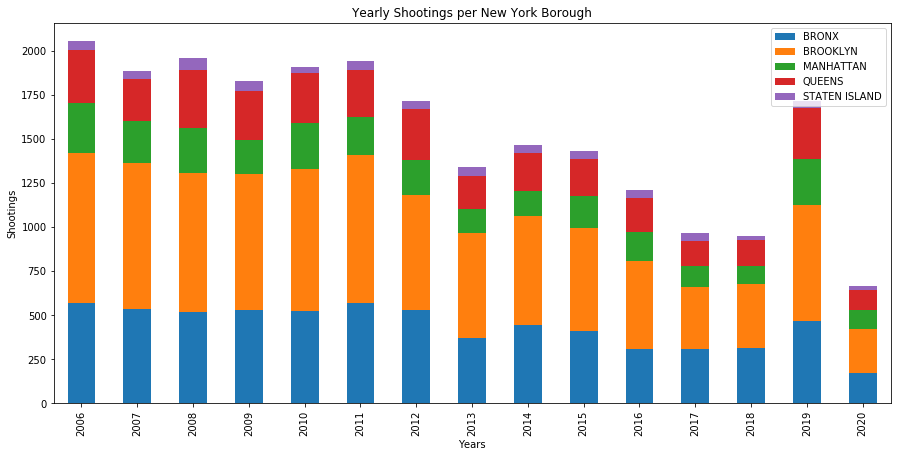

In [5]:
#Shootings grouped by year and borough
shooting_counts = shooting_df.groupby(["Year","BORO"])["Year"].count().unstack("BORO")

shooting_counts.plot(kind="bar",stacked=True,figsize=(15,7))
plt.legend(loc="best")
plt.title("Yearly Shootings per New York Borough")
plt.xlabel("Years")
plt.ylabel("Shootings")

# Save Shootings by Borough Image
plt.savefig("Images/NYC_Shootings_Borough.png")

plt.show()

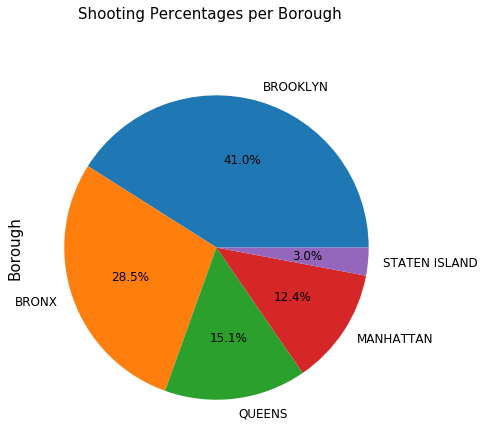

In [34]:
# Shooting percentages per borough
borough_shooting_pie = shooting_df.BORO.value_counts().plot(kind="pie",autopct='%1.1f%%',
                                                            figsize=(7,7),fontsize=12)

plt.ylabel("Borough",fontsize=15)
plt.suptitle("Shooting Percentages per Borough",fontsize=15)

# Save Shootings by Borough Image
plt.savefig("Images/NYC_Shootings_BoroughPercentages.png")

In [6]:
# Store latitude and longitude in locations
locations = shooting_df[["Latitude", "Longitude"]]

# Fill NaN values and convert to float
#weights = shooting_df["Year"].astype(float)

# Plot Heatmap
fig = gmaps.figure(center=(40.7128,-74.0060),zoom_level=10)

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations)

# Add layer
fig.add_layer(heat_layer)

gmaps.configure(api_key=g_key)
with open('Resources/Borough Boundaries.geojson') as f:
    geometry = json.load(f)
geojson_layer = gmaps.geojson_layer(geometry, fill_color="white", fill_opacity=0.0, stroke_weight=2)
fig.add_layer(geojson_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

### Question: Where are shootings more prevalent in New York (analyzed by borough)?

The Brooklyn borough has the most shootings than any of the other boroughs. 

## Demograpics of Victims

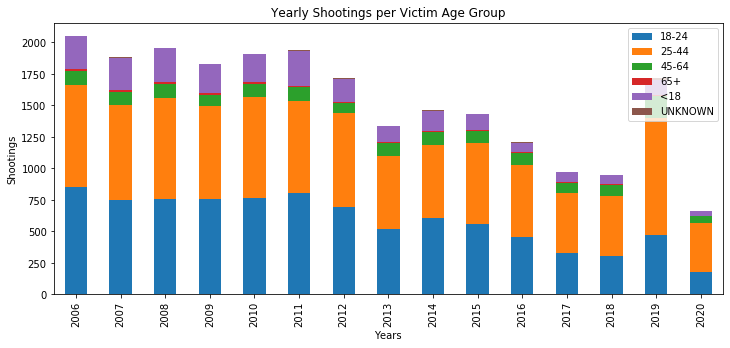

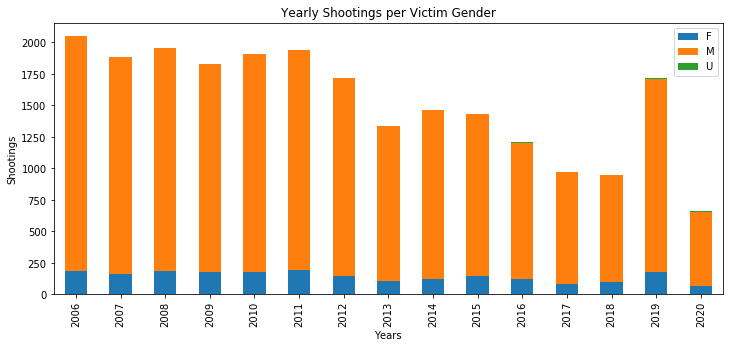

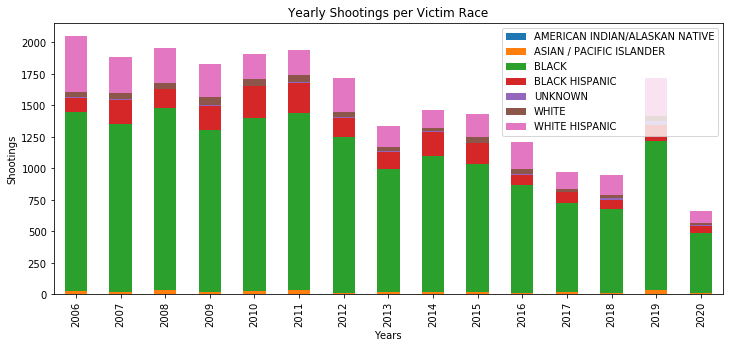

In [7]:
# Evaluating victom demographcs looking at age group, gender, and race
# Age Group
shooting_victim_age_counts = shooting_df.groupby(["Year","VIC_AGE_GROUP"])["Year"].count().unstack("VIC_AGE_GROUP")

shooting_victim_age_counts.plot(kind="bar",stacked=True,figsize=(12,5))
plt.legend(loc="upper right")

plt.title("Yearly Shootings per Victim Age Group")
plt.xlabel("Years")
plt.ylabel("Shootings")

# Save Age Group Image
plt.savefig("Images/NYC_Shootings_Demographics_AgeGroup.png")

# Gender
shooting_victim_sex_counts = shooting_df.groupby(["Year","VIC_SEX"])["Year"].count().unstack("VIC_SEX")

shooting_victim_sex_counts.plot(kind="bar",stacked=True,figsize=(12,5))
plt.legend(loc="best")

plt.title("Yearly Shootings per Victim Gender")
plt.xlabel("Years")
plt.ylabel("Shootings")

# Save Gender Image
plt.savefig("Images/NYC_Shootings_Demographics_Gender.png")

# Race
shooting_victim_race_counts = shooting_df.groupby(["Year","VIC_RACE"])["Year"].count().unstack("VIC_RACE")

shooting_victim_race_counts.plot(kind="bar",stacked=True,figsize=(12,5))
plt.legend(loc="best")

plt.title("Yearly Shootings per Victim Race")
plt.xlabel("Years")
plt.ylabel("Shootings")

# Save Race Image
plt.savefig("Images/NYC_Shootings_Demographics_Race.png")

plt.show()

### Question: What are the demographics of victims? Are there patterns/trends based on victim demographics?

In the age buckets, the predominate ages of shooting victims are the 18-24 and 25-44 age ranges. The 25-44 age range is the largest range of ages of shooting victims. There was a spike in this age range in 2019. 

The predominant gender of shooting victims are male. 

As far as race, a majority of the shooting victims are Black. The second closest race is White Hispanic.

## Shootings Over Time: Impact of Policing Strategies

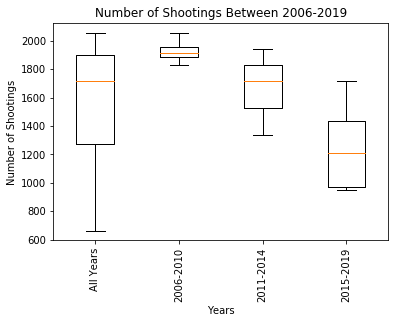

In [8]:
# Shootings Over Time - Bucketing by the years of different strategies

# All Years
shooting_year_groupby = shooting_df.groupby(["Year"])
shooting_year_counts = shooting_year_groupby["INCIDENT_KEY"].count()

# 2006-2010
shootings_2006_2010_df = shooting_df.loc[(shooting_df["Year"] >= 2006) &
                                        (shooting_df["Year"] < 2011)]
shooting_2006_2010_groupby = shootings_2006_2010_df.groupby(["Year"])
shooting_2006_2010_counts = shooting_2006_2010_groupby["INCIDENT_KEY"].count()

# 2011-2014 (4 years prior to neighborhood policing strategy)
shootings_2011_2014_df = shooting_df.loc[(shooting_df["Year"] >= 2011) &
                                        (shooting_df["Year"] < 2014)]
shooting_2011_2014_groupby = shootings_2011_2014_df.groupby(["Year"])
shooting_2011_2014_counts = shooting_2011_2014_groupby["INCIDENT_KEY"].count()

# 2015-2019 (4 years after the neighborhood policing strategy was implemented)
shootings_2015_df = shooting_df.loc[(shooting_df["Year"] >= 2015) &
                                        (shooting_df["Year"] < 2020)]
shooting_2015_groupby = shootings_2015_df.groupby(["Year"])
shooting_2015_counts = shooting_2015_groupby["INCIDENT_KEY"].count()

# Combine data to create box plot of the time frames
shooting_year_counts_df = pd.DataFrame(shooting_year_counts)
shooting_2006_2010_counts_df = pd.DataFrame(shooting_2006_2010_counts)
shooting_2011_2014_counts_df = pd.DataFrame(shooting_2011_2014_counts)
shooting_2015_counts_df = pd.DataFrame(shooting_2015_counts)

combine = [shooting_year_counts_df["INCIDENT_KEY"],
           shooting_2006_2010_counts_df["INCIDENT_KEY"],
           shooting_2011_2014_counts_df["INCIDENT_KEY"],
           shooting_2015_counts_df["INCIDENT_KEY"]]

year_groupings = ["All Years", "2006-2010", "2011-2014", "2015-2019"]
tick_locations = [1,2,3,4]

fig5,ax5 = plt.subplots()
ax5.set_ylabel("Number of Shootings")
ax5.set_xlabel("Years")
ax5.set_title("Number of Shootings Between 2006-2019")
outlier = dict(marker="o", markerfacecolor="red", markersize=10)
ax5.boxplot(combine,flierprops=outlier)
plt.xticks(tick_locations,year_groupings)
plt.xticks(rotation=90)

# Save statistical analysis box plot
plt.savefig("Images/NYC_Shootings_YearsAnalysis.png")

plt.show()

In [9]:
# Statistical Analysis in the year buckets
# Average of each year range
mean_shootings = np.mean(shooting_year_counts)
mean_shootings_2006_2010 = np.mean(shooting_2006_2010_counts)
mean_shootings_2011_2014 = np.mean(shooting_2011_2014_counts)
mean_shootings_2015_2019 = np.mean(shooting_2015_counts)

# Median
median_shootings = np.median(shooting_year_counts)
median_shootings_2006_2010 = np.median(shooting_2006_2010_counts)
median_shootings_2011_2014 = np.median(shooting_2011_2014_counts)
median_shootings_2015 = np.median(shooting_2015_counts)

# Mode
mode_shootings = sts.mode(shooting_year_counts)
mode_shootings_2006_2010 = sts.mode(shooting_2006_2010_counts)
mode_shootings_2011_2014 = sts.mode(shooting_2011_2014_counts)
mode_shootings_2015 = sts.mode(shooting_2015_counts)

perc_change = (mean_shootings_2011_2014 - mean_shootings_2015_2019) / mean_shootings_2011_2014 * 100

print(f"The mean shootings of all years 2006-2020 is {mean_shootings}")
print(f"The mean shootings of years 2006-2010 is {mean_shootings_2006_2010}")
print(f"The mean shootings of years 2011-2014 is {mean_shootings_2011_2014}")
print(f"The mean shootings of years 2015-2019 is {mean_shootings_2015_2019}")
print(f"")
print(f"The median shootings of all years 2006-2020 is {median_shootings}")
print(f"The median shootings of years 2006-2010 is {median_shootings_2006_2010}")
print(f"The median shootings of years 2011-2014 is {median_shootings_2011_2014}")
print(f"The median shootings of years 2015-2019 is {median_shootings_2015}")
print(f"")
print(f"The mode shootings of all years 2006-2020 is {mode_shootings}")
print(f"The mode shootings of years 2006-2010 is {mode_shootings_2006_2010}")
print(f"The mode shootings of years 2011-2014 is {mode_shootings_2011_2014}")
print(f"The mode shootings of years 2015-2019 is {mode_shootings_2015}")
print(f"")
print(f"The percent change of the average between 2011-2014 and 2015-2019 is {perc_change}%")

The mean shootings of all years 2006-2020 is 1535.9333333333334
The mean shootings of years 2006-2010 is 1927.6
The mean shootings of years 2011-2014 is 1665.0
The mean shootings of years 2015-2019 is 1255.6

The median shootings of all years 2006-2020 is 1716.0
The median shootings of years 2006-2010 is 1910.0
The median shootings of years 2011-2014 is 1717.0
The median shootings of years 2015-2019 is 1208.0

The mode shootings of all years 2006-2020 is ModeResult(mode=array([664], dtype=int64), count=array([1]))
The mode shootings of years 2006-2010 is ModeResult(mode=array([1828], dtype=int64), count=array([1]))
The mode shootings of years 2011-2014 is ModeResult(mode=array([1339], dtype=int64), count=array([1]))
The mode shootings of years 2015-2019 is ModeResult(mode=array([951], dtype=int64), count=array([1]))

The percent change of the average between 2011-2014 and 2015-2019 is 24.588588588588596%


In [73]:
shootings_2014_df = shooting_df.loc[shooting_df["Year"] == 2014]
shootings_2018_df = shooting_df.loc[shooting_df["Year"] == 2018]

shootings_2014_counts = shootings_2014_df.groupby(["ShootingMonth"]).count()
shootings_2018_counts = shootings_2018_df.groupby(["ShootingMonth"]).count()

counts_2014 = shootings_2014_counts["INCIDENT_KEY"]
counts_2018 = shootings_2018_counts["INCIDENT_KEY"]

correlation = sts.pearsonr(counts_2014,counts_2018)
print(f"The correlation between 2014 and 2018 is {round(correlation[0],2)}")

The correlation between 2014 and 2018 is 0.79


### Question: How were shooting incidents statistically impacted by implemented strategies? What were those percent changes?

In 2015, the Community Policing strategy was introduced. Between the years of 2015-2019 the number of shootings were reduced. The average shootings dropped by 24.6%. 

Looking at the p-value, between the year prior to the community policing and the last year the shooting counts dropped it is 0.79 signifying there is no statistical significance.

## Outliers

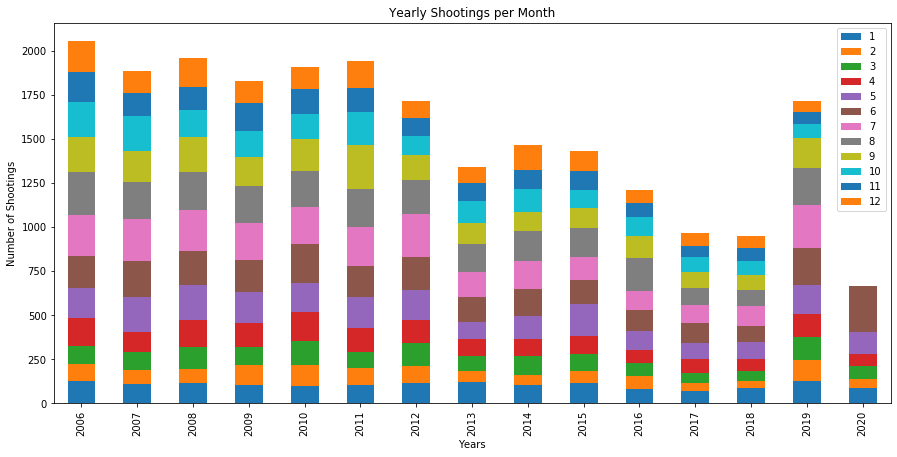

In [10]:
# Shooting Counts per year per month of that year
shooting_month_counts = shooting_df.groupby(["Year","ShootingMonth"])["Year"].count().unstack("ShootingMonth")

shooting_month_counts.plot(kind="bar",stacked=True,figsize=(15,7))
plt.legend(loc="best")
plt.title("Yearly Shootings per Month")
plt.xlabel("Years")
plt.ylabel("Number of Shootings")

# Save statistical analysis box plot
plt.savefig("Images/NYC_Shootings_YearMonthAnalysis.png")

plt.show()

In [11]:
# reseting the index
shooting_year_counts_df = shooting_year_counts_df.reset_index(drop=False)

The r-squared is: 0.6992422580428906


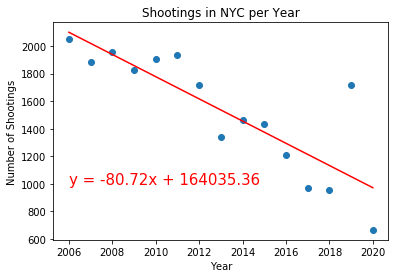

In [12]:
# Plotting the shooting counts per year and doing a linear regression
x_values = shooting_year_counts_df["Year"]
y_values = shooting_year_counts_df["INCIDENT_KEY"]
(slope,intercept,rvalue,pvalue,stderr) = linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(2006,1000),fontsize=15,color="red")
plt.xlabel('Year')
plt.ylabel('Number of Shootings')
plt.title("Shootings in NYC per Year")
print(f"The r-squared is: {rvalue**2}")

# Save statistical analysis box plot
plt.savefig("Images/NYC_Shootings_RegressionAnalysis.png")

plt.show()

In [13]:
# Grouping by the Year and Month to get the counts per year and month and placing that information in a dataframe
shooting_month_year_groupby = shooting_df.groupby(["Year","ShootingMonth"])
counts_year_month = shooting_month_year_groupby["INCIDENT_KEY"].count()
counts_year_month_df = pd.DataFrame(counts_year_month)

In [14]:
# Resetting the index
counts_year_month_df.reset_index(inplace=True)

In [15]:
# Renaming the columns from numbers to the month name
counts_year_month_df["ShootingMonth"] = counts_year_month_df["ShootingMonth"].replace({
    1:"January",
    2:"February",
    3:"March",
    4:"April",
    5:"May",
    6:"June",
    7:"July",
    8:"August",
    9:"September",
    10:"October",
    11:"November",
    12:"December"
})

# For 2020, only have data from Jan-June. Creating records for the rest of the year.
rest_of_year_2020 = [ 
    (2020,'July',0),
    (2020,'August',0),
    (2020,'September',0),
    (2020,'October',0),
    (2020,'November',0),
    (2020,'December',0)
]

# making the rest_of_year a dataframe and adding column names
rest_of_year_2020_df = pd.DataFrame(rest_of_year_2020)
rest_of_year_2020_df = rest_of_year_2020_df.rename(columns={0:"Year",1:"ShootingMonth",2:"INCIDENT_KEY"})

In [16]:
# Appending the rest of the data with the rest of the year data
all_months_years_df = counts_year_month_df.append(rest_of_year_2020_df, ignore_index=True)

In [17]:
# Creating a data frame for 2018, 2019, and 2020
# 2019 saw an increase in shootings. Comparing the year prior and the current year
counts_year_month_2018_df = all_months_years_df.loc[all_months_years_df["Year"] == 2018]
counts_year_month_2019_df = all_months_years_df.loc[all_months_years_df["Year"] == 2019]
counts_year_month_2020_df = all_months_years_df.loc[all_months_years_df["Year"] == 2020]

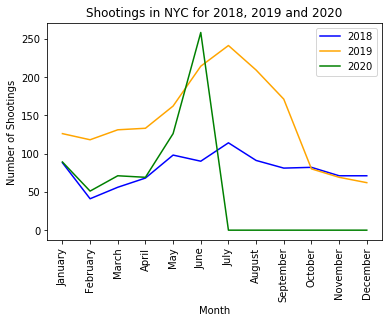

In [18]:
# Creating a line graph of 2018, 2019, 2020
x_axis = all_months_years_df["ShootingMonth"].unique()

y_axis_2018 = counts_year_month_2018_df["INCIDENT_KEY"]
y_axis_2019 = counts_year_month_2019_df["INCIDENT_KEY"]
y_axis_2020 = counts_year_month_2020_df["INCIDENT_KEY"]

year_2018, = plt.plot(x_axis, y_axis_2018, color="blue", label="2018" )

years_2018_2019, = plt.plot(x_axis,y_axis_2019,label="2019",color="orange")

years_2018_2019_2020, = plt.plot(x_axis,y_axis_2020,label="2020",color="green")

# Create a legend for our chart
plt.legend(handles=[year_2018,years_2018_2019, years_2018_2019_2020], loc="best")
plt.xticks(rotation=90)

plt.xlabel('Month')
plt.ylabel('Number of Shootings')
plt.title("Shootings in NYC for 2018, 2019 and 2020")

# Save statistical analysis box plot
plt.savefig("Images/NYC_Shootings_Years2018_2019_2020_Analysis.png")

# Show the chart
plt.show()

In [19]:
# Percent change in total shootings between 2018 and 2019
shootings_2018_df = shooting_df.loc[shooting_df["Year"] == 2018]
shooting_counts_2018 = shootings_2018_df["INCIDENT_KEY"].count()

shootings_2019_df = shooting_df.loc[shooting_df["Year"] == 2019]
shooting_counts_2019 = shootings_2019_df["INCIDENT_KEY"].count()

perc_chg_2018_2019 = (shooting_counts_2019 - shooting_counts_2018) / shooting_counts_2019 * 100

print(f"The shooting counts in 2018 are {shooting_counts_2018}")
print(f"The shooting counts in 2019 are {shooting_counts_2019}")
print(f"The percentage change between 2018 and 2019 is {perc_chg_2018_2019}%")

The shooting counts in 2018 are 951
The shooting counts in 2019 are 1716
The percentage change between 2018 and 2019 is 44.58041958041958%


In [20]:
# Percent change in total shootings between 20182019
shootings_2018_June_df = shooting_df.loc[(shooting_df["Year"] == 2018) & (shooting_df["ShootingMonth"] == 6)]
shooting_counts_June_2018 = shootings_2018_June_df["INCIDENT_KEY"].count()

shootings_2019_June_df = shooting_df.loc[(shooting_df["Year"] == 2019) & (shooting_df["ShootingMonth"] == 6)]
shooting_counts_June_2019 = shootings_2019_June_df["INCIDENT_KEY"].count()

shootings_2020_June_df = shooting_df.loc[(shooting_df["Year"] == 2020) & (shooting_df["ShootingMonth"] == 6)]
shooting_counts_June_2020 = shootings_2020_June_df["INCIDENT_KEY"].count()

perc_chg_2018_2020_June = (shooting_counts_June_2020 - shooting_counts_June_2018) / shooting_counts_June_2020 * 100
perc_chg_2019_2020_June = (shooting_counts_June_2020 - shooting_counts_June_2019) / shooting_counts_June_2020 * 100

print(f"The shooting counts in 2018 are {shooting_counts_June_2018}")
print(f"The shooting counts in 2019 are {shooting_counts_June_2019}")
print(f"The shooting counts in 2020 are {shooting_counts_June_2020}")

print(f"The percentage change between June 2018 and June 2020 is {perc_chg_2018_2020_June}%")
print(f"The percentage change between June 2019 and June 2020 is {perc_chg_2019_2020_June}%")

The shooting counts in 2018 are 90
The shooting counts in 2019 are 214
The shooting counts in 2020 are 258
The percentage change between June 2018 and June 2020 is 65.11627906976744%
The percentage change between June 2019 and June 2020 is 17.05426356589147%


## Question: What outliers were discovered in the data that had an impact on the crime rate? Are there geographical impacts?

In the year buckets created before and after the policing strategies were implemented, there were not outliers in the data.

There was a 44.6% increase in shootings between 2018 and 2019. Upon further investigation, NY has noted that the number of shootings did increase in 2019 but currently are not seeing it as statistically relevant. Looking at the regression line, even with the spike of shootings in 2019 the shootings are still trending down.

In 2020 so far, NYC has seen a spike of shootings in the month of June. Prior to June, 2020 was trending like 2018 before the increase in June. Comparing June 2018 and June 2020, the number of shootings increased by 65.1%. Comparing June 2019 and June 2020, the number of shootings increased by 17.1%. With the world dealing with COVID, there have been spikes in crime. More criminals are being released due to the virus. NYC has seen budget cuts; therefore reducing the amount of recruits by 1,163. There have been more officers retiring. Also, civil unrest has attributed in crime. 

## Question: How has their policing approach changed over time? Did they combine methodologies during the period evaluated?

NYC did combine many methodologies over the time but there is no way to conclusively know which methods worked and which ones did not. It does appear that the community policing may have contributed to a decline in shootings when it was implemented but there could have been other programs concurrently happening that aided in the decrease of shootings. 